# 1. Interpolation of the raw data and exploration of the interpolated data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from osgeo import gdal
import xarray as xr

The raw data was previously saved as a pickle and consists of 962565 point measurements of 12 variables. Only 6 variables will be used, corresponding to measurements of apparent electrical conductivity of 6 soil volumes. The 6 omitted variables (IP components) measure magnetic properties and are sensitive to drift of the measuring instrument. Since the data was collected in multiple surveys, the variation in the IP components are strongly affected by drift.

In [3]:
df = pd.read_pickle('../Data/prosperpolder.pkl')
df5000 = df.sample(5000, random_state=856) # Random subset of 5000 locations to be able to quickly test code.

vars_list = list(df.columns[range(4,10)]) # List of variable names

Then the data is transformed to a geodataframe which correctly recognizes the coordinates of the points in CRS UTM 31N.

In [4]:
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(x=df['x'], y=df['y']), crs="EPSG:32631")
gdf5000 = geopandas.GeoDataFrame(df5000, geometry=geopandas.points_from_xy(x=df5000['x'], y=df5000['y']), crs="EPSG:32631")

## Interpolation (IDW)

The point data is interpolated to raster data using the GDAL library.

In [5]:
# Function to easily interpolate the dataset using IDW

def IDW(power, output_file, input_file, width, height, zfield, radius):
    options = gdal.GridOptions(format="GTiff", 
                               outputSRS="EPSG:32631", 
                               algorithm=("invdist:power="+str(power)+":radius1="+str(radius)+":radius2="+str(radius)+":nodata=-999.0"), #Nan=-999
                               width=width, height=height, zfield=zfield)
    raster = gdal.Grid(output_file, input_file, options=options )
    raster = None

### Test with 5000 random observations

In [6]:
# gdf5000.to_file("../Data/Data_geojson/gdf5000.geojson", driver="GeoJSON")
multipoints = gdf5000.dissolve()
bounds = multipoints.bounds.squeeze()

In [7]:
xres = 10
yres = 10
w = round((bounds['maxx'] - bounds['minx'])/xres) # w and h needed as arguments for IDW, calculated from specified pixelsize
h = round((bounds['maxy'] - bounds['miny'])/yres)
raster = IDW(2, "Interpolations/test.tiff", "../Data/Data_geojson/gdf5000.geojson", w, h, 'HCP4QP', radius=50)

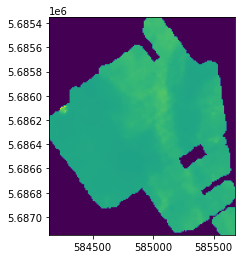

In [8]:
# Visualization of the interpolation using rasterio
import rasterio
from rasterio.plot import plotting_extent
with rasterio.open("Interpolations/test.tiff") as src:
    test = src.read()
    test_extent = plotting_extent(src)
    
plt.imshow(test.transpose(1,2,0), extent=test_extent, origin='lower') # Image plot of the test interpolation

### Interpolation for all layers using IDW, power = 2, res=10mx10m

Using the previously defined function, all layers of interest are interpolated using Inverse Distance Weighting (IDW) to a raster with pixel size 10m x 10m. Raster values are calculated by taking a weighted sum of points within 30m distance, with weights equal to the inverse of the squared distance to the centre of the pixel.

In [26]:
# gdf.to_file('../Data/Data_geojson/gdf.geojson', driver='GeoJSON')

# Set parameters:
xres = 10
yres = 10
w = round((bounds['maxx'] - bounds['minx'])/xres)
h = round((bounds['maxy'] - bounds['miny'])/yres)
r = 30

for var in vars_list:
    raster = IDW(2, "Interpolations/IDW_10" + 
                 var + ".tiff", "../Data/Data_geojson/gdf.geojson", w, h, zfield=var, radius=r)

## Create dataframe from raster data

The clustering algorithms require the input data in a table format. Therefore, dataframes are created that contain the exact same information as the raster files.

In [70]:
vars_vec = df.columns[range(4,10)]

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=([vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.assign_coords(band=([vars_vec[i]]))
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer_data[vars_vec[i]]
    i += 1

stack_array = stack_data.to_array(dim="band")

df_raster = stack_data.to_dataframe()[vars_vec]

## Data exploration

The 6 layers of the raster can be plotted seperately.

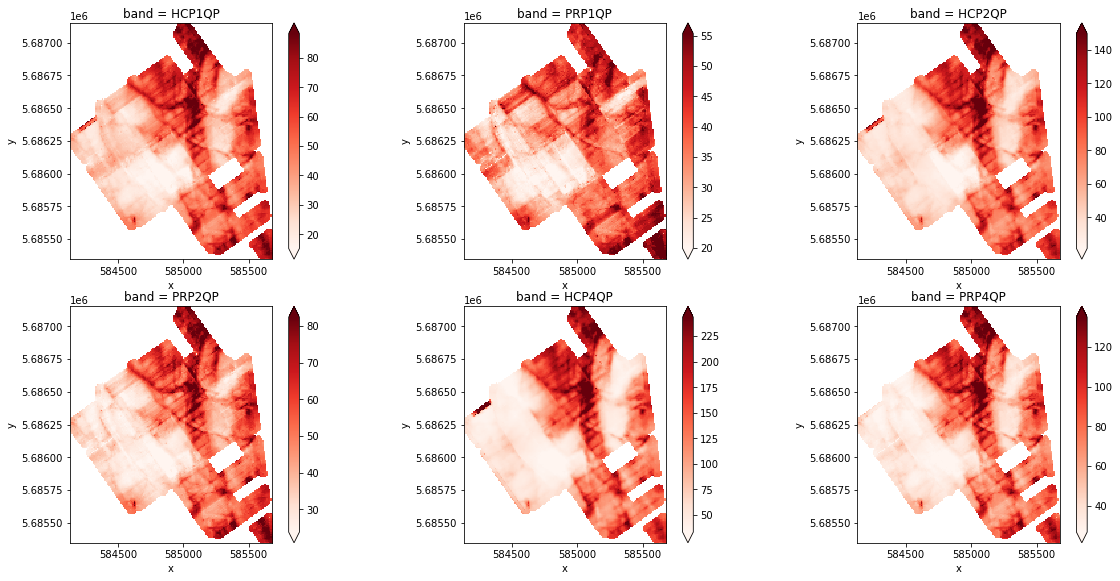

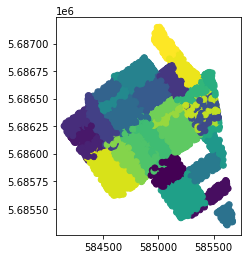

In [58]:
stack_array = stack_data.to_array(dim="band")

fig = plt.figure(figsize=(20,20))

i=1
for var in vars_vec:
    ax = fig.add_subplot(4,3,i)
    ax = stack_array.sel(band=var).plot.imshow(robust=True, cmap="Reds")
    ax.axes.set_aspect('equal')
    i += 1

gdf5000.plot(column='survey')
plt.show()

To get a feeling of the distribution of the variables, histograms are plotted. It is also clear the the 6 variables are highly correlated since they all measure the electrical conductivity of the soil. 

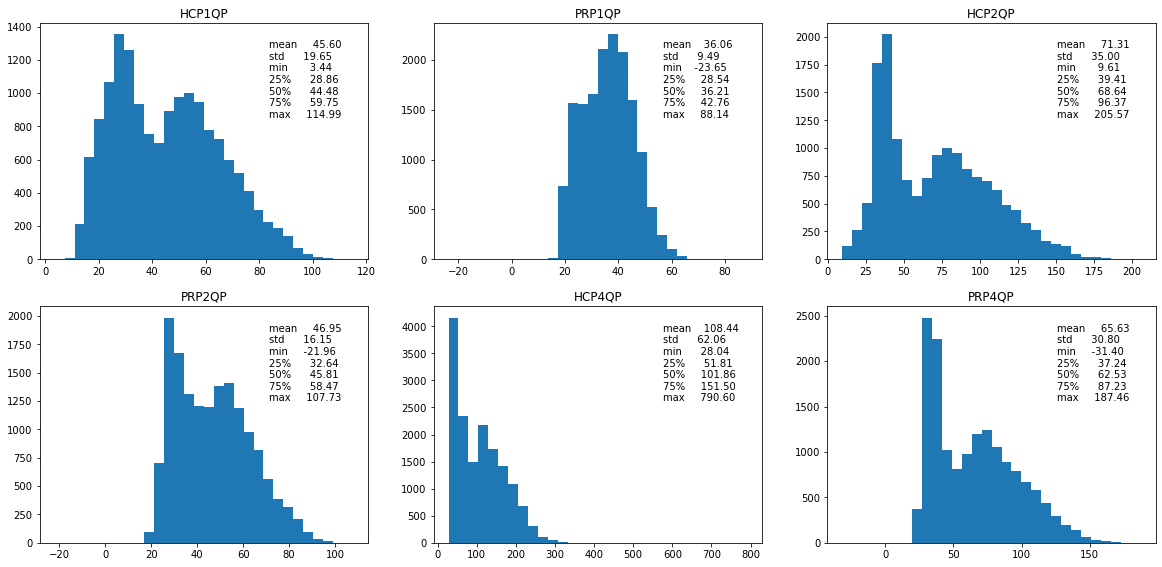

In [59]:
rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[vars_vec][~rows_with_nan]

fig = plt.figure(figsize=(20,20))

i=1
for var in vars_list:
    ax = fig.add_subplot(4,3,i)
    ax.hist(df_nona[var], bins=30)
    ax.title.set_text(var)
    i += 1
    ax.annotate(text=df_nona[var].describe().round(decimals=2).loc[['mean','std','min','25%','50%','75%','max']].to_string(), 
                xy=(0.7,0.6), xycoords='axes fraction')

The distributions seem to be bimodal.

In [12]:
corr = df_nona[vars_list].corr()
corr.style.background_gradient(cmap='coolwarm')

,HCP1QP,PRP1QP,HCP2QP,PRP2QP,HCP4QP,PRP4QP
HCP1QP,1.000000,0.853321,0.981664,0.972132,0.934263,0.967985
PRP1QP,0.853321,1.000000,0.762698,0.900009,0.665545,0.775442
HCP2QP,0.981664,0.762698,1.000000,0.946908,0.972100,0.981242
PRP2QP,0.972132,0.900009,0.946908,1.000000,0.873248,0.965456
HCP4QP,0.934263,0.665545,0.972100,0.873248,1.000000,0.938685
PRP4QP,0.967985,0.775442,0.981242,0.965456,0.938685,1.000000


### PCA on the raster data

By means of a principal components analysis, we can get an idea of how the data looks like in 6 dimensional feature space since we can derive the projection in 2D that preserves most of the variation. This could already reveal clustering patterns or certain trends.

In [60]:
from sklearn import preprocessing as prep
from matplotlib import gridspec

df_std = np.array(prep.StandardScaler().fit_transform(df_nona)) # Data is standardized for PCA since the range is quite different for the different vars

U, delta, Vt = np.linalg.svd(df_std, full_matrices=0)


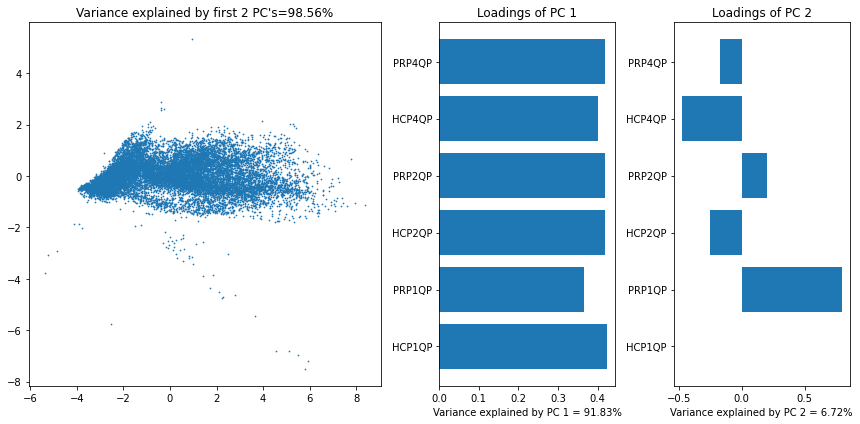

In [61]:
rel_var = delta**2/ sum(delta**2) *100

#plt.bar(range(1,13), rel_var)

title = "Variance explained by first 2 PC's=" + str(np.round(rel_var[:2].sum(), decimals=2)) + "%"

# To plot the data in 2 dimensions:
delta_k = np.diag(delta[range(2)])
Uk = U[:, 0:2]
Zk = np.matmul(Uk, delta_k)


V = Vt.T
Vk = V[:,:2]
RelvarPC1 = np.round(rel_var[0], decimals=2)
RelvarPC2 = np.round(rel_var[1], decimals=2)


fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(12,6),
                                   gridspec_kw={'width_ratios':[2, 1, 1]})

ax0.scatter(x=Zk[:,0], y=Zk[:,1], s=0.5)
ax0.set_title(title)

ax1.barh(vars_vec, Vk[:,0])
ax1.set_title('Loadings of PC 1')
ax1.set_xlabel('Variance explained by PC 1 = ' + str(RelvarPC1) + '%')

ax2.barh(vars_vec, Vk[:,1])
ax2.set_title('Loadings of PC 2')
ax2.set_xlabel('Variance explained by PC 2 = ' + str(RelvarPC2) + '%')

plt.tight_layout()
plt.show()

The first PC gives the general trend of highly conductive soils to less conductive soils which accounts for over 90% of the variance in the data. The second PC differentiates mainly between locations that have a high measurement on PRP1QP and those that have a high measurement on HCP4QP.\
The scatterplot of the 2 most important PC's does not show any clear clustering though there are some areas with a higher density as well as several outlying observations. For a group of these outlying observations the PC's seem negatively correlated.

Both components can also be mapped to understand their spatial distribution.

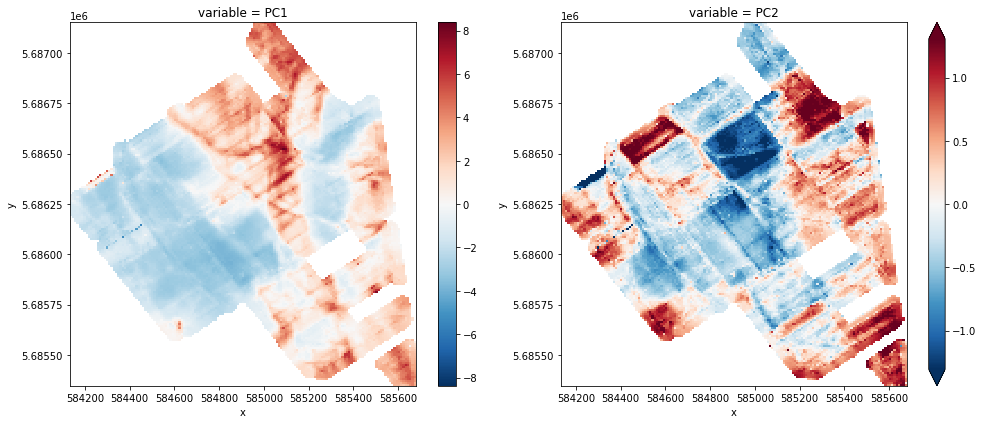

In [95]:
PC1 = np.empty((27540))
PC1[:] = np.nan
PC1[~rows_with_nan] = Zk[:,0]

PC2 = np.empty((27540))
PC2[:] = np.nan
PC2[~rows_with_nan] = Zk[:,1]

df_raster['PC1'] = PC1
df_raster['PC2'] = PC2

stack_data = df_raster.to_xarray().transpose('y', 'x')
stack_array = stack_data.to_array()

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(14,6))

stack_array.sel(variable='PC1').plot(ax=ax0)
stack_array.sel(variable='PC2').plot(ax=ax1, robust=True)
plt.tight_layout()
plt.show()